In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report

from tensorflow.keras.applications import DenseNet121, ResNet50, EfficientNetB0
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
data = pd.read_csv("dataset/HAM10000_metadata.csv")

In [13]:
target_size = 1000
balanced_data = data.groupby('dx', group_keys=False).apply(
    lambda x: x.sample(n=target_size, replace=True, random_state=42)
).reset_index(drop=True)

/var/folders/yz/bms59l5j5cl16ztb19ty54s40000gn/T/ipykernel_96038/2683717389.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_data = data.groupby('dx', group_keys=False).apply(


In [35]:
balanced_data, test_data = train_test_split(balanced_data, test_size=0.3, random_state=42)

In [15]:
balanced_data['image_id'] = balanced_data['image_id'].apply(lambda x: x + '.jpg')

In [16]:
datagen = ImageDataGenerator(
    validation_split=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    zoom_range=0.3,
    shear_range=0.2,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_dataframe(
    dataframe=balanced_data,
    directory='./dataset/data_with_mask_otsu',
    x_col='image_id',
    y_col='dx',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=balanced_data,
    directory='./dataset/data_with_mask_otsu',
    x_col='image_id',
    y_col='dx',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

def create_model(base_model_fn, input_shape, num_classes):
    base_model = base_model_fn(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

input_shape = (128, 128, 3)
num_classes = len(train_generator.class_indices)
epochs = 30


models = {
    #"DenseNet121": DenseNet121,
    "ResNet50": ResNet50,
    #"EfficientNetB0": EfficientNetB0
}

for model_name, base_model_fn in models.items():
    print(f"Training {model_name}...")
    model = create_model(base_model_fn, input_shape, num_classes)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        callbacks=[early_stopping]
    )

    model.save(f'{model_name}_model.h5', save_format='h5')
    print(f"{model_name} training completed and model saved!")


Found 3430 validated image filenames belonging to 7 classes.


Found 1470 validated image filenames belonging to 7 classes.
Training ResNet50...
Epoch 1/30


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


108/108 ━━━━━━━━━━━━━━━━━━━━ 35s 309ms/step - accuracy: 0.3003 - loss: 1.9582 - val_accuracy: 0.5190 - val_loss: 1.2653
Epoch 2/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 33s 307ms/step - accuracy: 0.4935 - loss: 1.3312 - val_accuracy: 0.5898 - val_loss: 1.1181
Epoch 3/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 36s 337ms/step - accuracy: 0.5442 - loss: 1.2271 - val_accuracy: 0.6000 - val_loss: 1.0625
Epoch 4/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 37s 343ms/step - accuracy: 0.5639 - loss: 1.1573 - val_accuracy: 0.6381 - val_loss: 0.9909
Epoch 5/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 37s 341ms/step - accuracy: 0.5660 - loss: 1.1189 - val_accuracy: 0.6490 - val_loss: 0.9563
Epoch 6/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 36s 329ms/step - accuracy: 0.6139 - loss: 1.0481 - val_accuracy: 0.6367 - val_loss: 0.9627
Epoch 7/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 36s 333ms/step - accuracy: 0.6147 - loss: 1.0212 - val_accuracy: 0.6585 - val_loss: 0.9184
Epoch 8/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 33s 309ms/step - accuracy: 0.6234 - loss: 1.0004 - val

ResNet50 training completed and model saved!


In [27]:
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")

Training samples: 3430
Validation samples: 1470


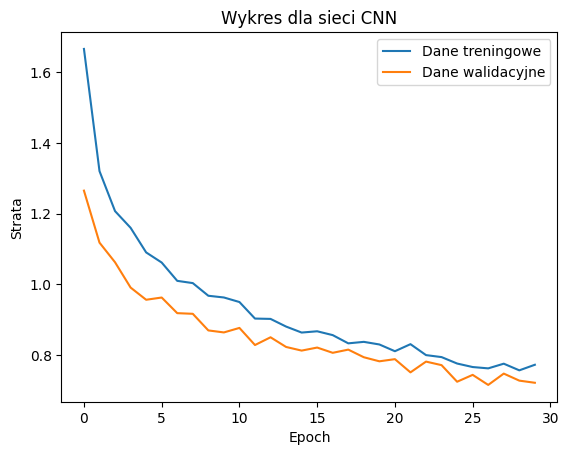

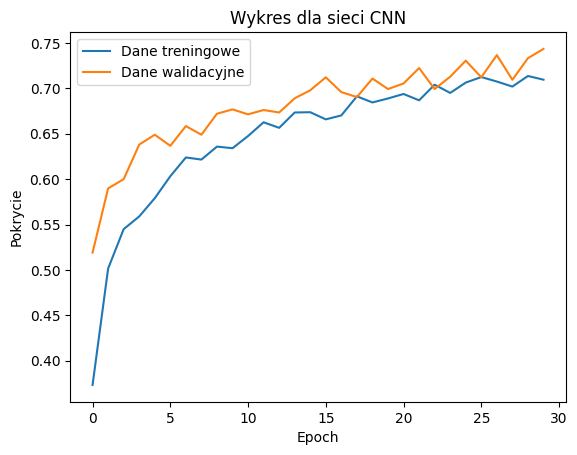

In [28]:
metrics = ['loss', 'accuracy']
metryki = ['Strata', 'Pokrycie']
i = 0
for metric in metrics:
    plt.plot(history.history[metric], label='Dane treningowe')
    plt.plot(history.history[f'val_{metric}'], label='Dane walidacyjne')
    plt.xlabel('Epoch')
    plt.ylabel(metryki[i])
    plt.legend(loc='best')
    plt.title("Wykres dla sieci ResNet50")
    plt.show()
    i += 1

In [19]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 24,377,239 (92.99 MB)

 Trainable params: 263,175 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 526,352 (2.01 MB)

In [36]:
test_data

,lesion_id,image_id,dx,dx_type,age,sex,localization
1082,HAM_0000868,ISIC_0032316.jpg,bcc,histo,65.0,male,face
5681,HAM_0000763,ISIC_0028217.jpg,nv,histo,35.0,female,back
489,HAM_0005255,ISIC_0030158.jpg,akiec,histo,55.0,male,upper extremity
6421,HAM_0004765,ISIC_0031217.jpg,vasc,histo,15.0,male,face
637,HAM_0001967,ISIC_0025471.jpg,akiec,histo,85.0,male,chest
...,...,...,...,...,...,...,...
3022,HAM_0002871,ISIC_0027044.jpg,df,consensus,35.0,female,lower extremity
3803,HAM_0002895,ISIC_0029578.jpg,df,histo,60.0,male,lower extremity
5295,HAM_0002305,ISIC_0029693.jpg,nv,histo,55.0,male,back
2866,HAM_0000245,ISIC_0027454.jpg,bkl,histo,75.0,female,back


In [32]:
test_data['image_id'] = test_data['image_id'].apply(lambda x: x + '.jpg')

In [37]:
test_generator = datagen.flow_from_dataframe(
    dataframe=test_data,
    directory='/Users/htlusty/Documents/DYPLOMA/dataset/data_with_mask_otsu',
    x_col='image_id',
    y_col='dx',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  
)

Found 1029 validated image filenames belonging to 7 classes.


In [38]:
y_pred_probs = model.predict(test_generator) 
y_pred = np.argmax(y_pred_probs, axis=1)    

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step


In [39]:
y_true = test_generator.classes 

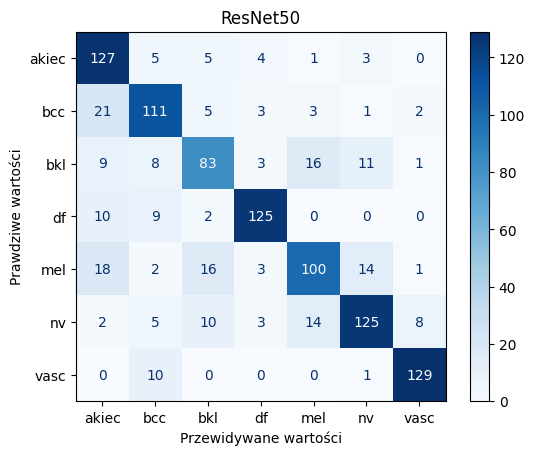

In [40]:
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)

plt.xlabel("Przewidywane wartości")
plt.ylabel("Prawdziwe wartości")
plt.title("ResNet50")
plt.show()

In [41]:
report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
print(report)

              precision    recall  f1-score   support

       akiec       0.68      0.88      0.77       145
         bcc       0.74      0.76      0.75       146
         bkl       0.69      0.63      0.66       131
          df       0.89      0.86      0.87       146
         mel       0.75      0.65      0.69       154
          nv       0.81      0.75      0.78       167
        vasc       0.91      0.92      0.92       140

    accuracy                           0.78      1029
   macro avg       0.78      0.78      0.78      1029
weighted avg       0.78      0.78      0.78      1029



# Unbalanced dataset

In [43]:
data = pd.read_csv("dataset/HAM10000_metadata.csv")

In [44]:
data, test_data = train_test_split(data, test_size=0.3, random_state=42)

In [45]:
data['image_id'] = data['image_id'].apply(lambda x: x + '.jpg')

In [46]:
datagen = ImageDataGenerator(
    validation_split=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    zoom_range=0.3,
    shear_range=0.2,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_dataframe(
    dataframe=data,
    directory='/Users/htlusty/Documents/DYPLOMA/dataset/data_with_mask_otsu',
    x_col='image_id',
    y_col='dx',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=data,
    directory='/Users/htlusty/Documents/DYPLOMA/dataset/data_with_mask_otsu',
    x_col='image_id',
    y_col='dx',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

def create_model(base_model_fn, input_shape, num_classes):
    base_model = base_model_fn(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

input_shape = (128, 128, 3)
num_classes = len(train_generator.class_indices)
epochs = 30


models = {
    #"DenseNet121": DenseNet121,
    "ResNet50": ResNet50,
    #"EfficientNetB0": EfficientNetB0
}

for model_name, base_model_fn in models.items():
    print(f"Training {model_name}...")
    model = create_model(base_model_fn, input_shape, num_classes)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        callbacks=[early_stopping]
    )

    model.save(f'{model_name}_model_unbalanced.h5', save_format='h5')
    print(f"{model_name} training completed and model saved!")


Found 4907 validated image filenames belonging to 7 classes.
Found 2103 validated image filenames belonging to 7 classes.
Training ResNet50...
Epoch 1/30


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


154/154 ━━━━━━━━━━━━━━━━━━━━ 45s 278ms/step - accuracy: 0.6259 - loss: 1.2522 - val_accuracy: 0.7047 - val_loss: 0.8167
Epoch 2/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 42s 270ms/step - accuracy: 0.7112 - loss: 0.8281 - val_accuracy: 0.7142 - val_loss: 0.7774
Epoch 3/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 43s 280ms/step - accuracy: 0.7088 - loss: 0.8144 - val_accuracy: 0.7228 - val_loss: 0.7475
Epoch 4/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 44s 284ms/step - accuracy: 0.7345 - loss: 0.7541 - val_accuracy: 0.7299 - val_loss: 0.7158
Epoch 5/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 45s 291ms/step - accuracy: 0.7245 - loss: 0.7497 - val_accuracy: 0.7456 - val_loss: 0.7144
Epoch 6/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 44s 284ms/step - accuracy: 0.7382 - loss: 0.7335 - val_accuracy: 0.7442 - val_loss: 0.7123
Epoch 7/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 42s 275ms/step - accuracy: 0.7401 - loss: 0.7235 - val_accuracy: 0.7418 - val_loss: 0.7021
Epoch 8/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 43s 277ms/step - accuracy: 0.7564 - loss: 0.6810 - val

ResNet50 training completed and model saved!


In [47]:
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")

Training samples: 4907
Validation samples: 2103


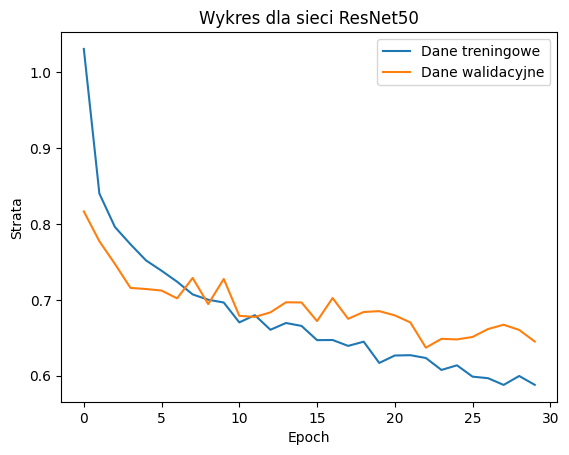

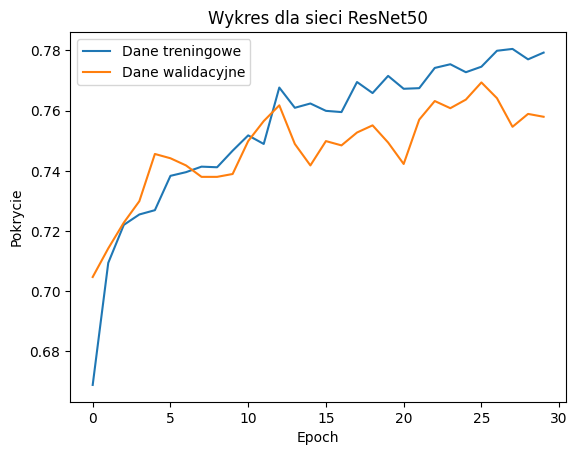

In [48]:
metrics = ['loss', 'accuracy']
metryki = ['Strata', 'Pokrycie']
i = 0
for metric in metrics:
    plt.plot(history.history[metric], label='Dane treningowe')
    plt.plot(history.history[f'val_{metric}'], label='Dane walidacyjne')
    plt.xlabel('Epoch')
    plt.ylabel(metryki[i])
    plt.legend(loc='best')
    plt.title("Wykres dla sieci ResNet50")
    plt.show()
    i += 1

In [50]:
test_data['image_id'] = test_data['image_id'].apply(lambda x: x + '.jpg')

In [51]:
test_data['image_id']

1617    ISIC_0033272.jpg
8128    ISIC_0031923.jpg
2168    ISIC_0026652.jpg
1090    ISIC_0030583.jpg
7754    ISIC_0034010.jpg
              ...       
4635    ISIC_0032121.jpg
8386    ISIC_0028706.jpg
3707    ISIC_0028102.jpg
1839    ISIC_0033055.jpg
1995    ISIC_0030970.jpg
Name: image_id, Length: 3005, dtype: object

In [52]:
test_generator = datagen.flow_from_dataframe(
    dataframe=test_data,
    directory='./dataset/data_with_mask_otsu',
    x_col='image_id',
    y_col='dx',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  
)
y_pred_probs = model.predict(test_generator) 
y_pred = np.argmax(y_pred_probs, axis=1)    
y_true = test_generator.classes  

Found 3005 validated image filenames belonging to 7 classes.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 207ms/step


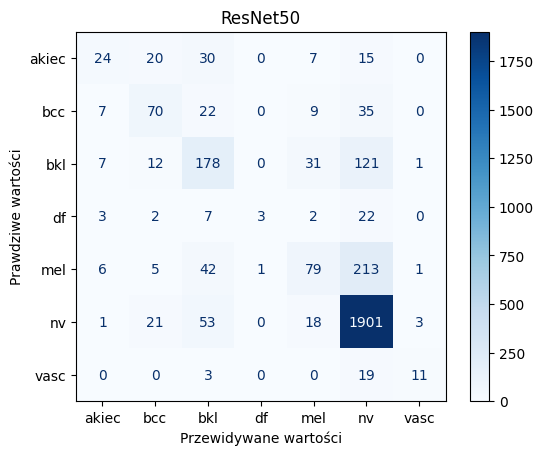

In [53]:
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)

plt.xlabel("Przewidywane wartości")
plt.ylabel("Prawdziwe wartości")
plt.title("ResNet50")
plt.show()

In [54]:
report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
print(report)

              precision    recall  f1-score   support

       akiec       0.50      0.25      0.33        96
         bcc       0.54      0.49      0.51       143
         bkl       0.53      0.51      0.52       350
          df       0.75      0.08      0.14        39
         mel       0.54      0.23      0.32       347
          nv       0.82      0.95      0.88      1997
        vasc       0.69      0.33      0.45        33

    accuracy                           0.75      3005
   macro avg       0.62      0.41      0.45      3005
weighted avg       0.73      0.75      0.72      3005



# Binary

Unbalanced

In [55]:
df = pd.read_csv("dataset/HAM10000_metadata.csv")

In [56]:
df_binary = df.copy()

In [57]:
df_binary['binary_disease'] = df_binary['dx'].apply(lambda x: 'mel' if x == 'mel' else 'non-mel')

In [58]:
data, test_data = train_test_split(df_binary, test_size=0.3, random_state=42)

In [59]:
data['image_id'] = data['image_id'].apply(lambda x: x + '.jpg')


In [60]:
datagen = ImageDataGenerator(
    validation_split=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    zoom_range=0.3,
    shear_range=0.2,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_dataframe(
    dataframe=data,
    directory='./dataset/data_with_mask_otsu',
    x_col='image_id',
    y_col='binary_disease',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=data,
    directory='./dataset/data_with_mask_otsu',
    x_col='image_id',
    y_col='binary_disease',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

def create_model(base_model_fn, input_shape, num_classes):
    base_model = base_model_fn(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

input_shape = (128, 128, 3)
num_classes = len(train_generator.class_indices)
epochs = 30


models = {
    #"DenseNet121": DenseNet121,
    "ResNet50": ResNet50,
    #"EfficientNetB0": EfficientNetB0
}

for model_name, base_model_fn in models.items():
    print(f"Training {model_name}...")
    model = create_model(base_model_fn, input_shape, num_classes)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        callbacks=[early_stopping]
    )

    model.save(f'{model_name}_model_binary_unbalanced.h5', save_format='h5')
    print(f"{model_name} training completed and model saved!")


Found 4907 validated image filenames belonging to 2 classes.
Found 2103 validated image filenames belonging to 2 classes.
Training ResNet50...
Epoch 1/30


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


154/154 ━━━━━━━━━━━━━━━━━━━━ 46s 284ms/step - accuracy: 0.8594 - loss: 0.4505 - val_accuracy: 0.8883 - val_loss: 0.2730
Epoch 2/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 43s 278ms/step - accuracy: 0.8961 - loss: 0.2726 - val_accuracy: 0.8944 - val_loss: 0.2632
Epoch 3/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 43s 276ms/step - accuracy: 0.8911 - loss: 0.2699 - val_accuracy: 0.8897 - val_loss: 0.2593
Epoch 4/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 42s 272ms/step - accuracy: 0.8929 - loss: 0.2739 - val_accuracy: 0.8982 - val_loss: 0.2563
Epoch 5/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 42s 274ms/step - accuracy: 0.8988 - loss: 0.2512 - val_accuracy: 0.8925 - val_loss: 0.2533
Epoch 6/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 42s 275ms/step - accuracy: 0.8946 - loss: 0.2575 - val_accuracy: 0.8940 - val_loss: 0.2549
Epoch 7/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 42s 276ms/step - accuracy: 0.8963 - loss: 0.2474 - val_accuracy: 0.8916 - val_loss: 0.2445
Epoch 8/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 43s 279ms/step - accuracy: 0.9046 - loss: 0.2474 - val

ResNet50 training completed and model saved!


In [61]:
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")

Training samples: 4907
Validation samples: 2103


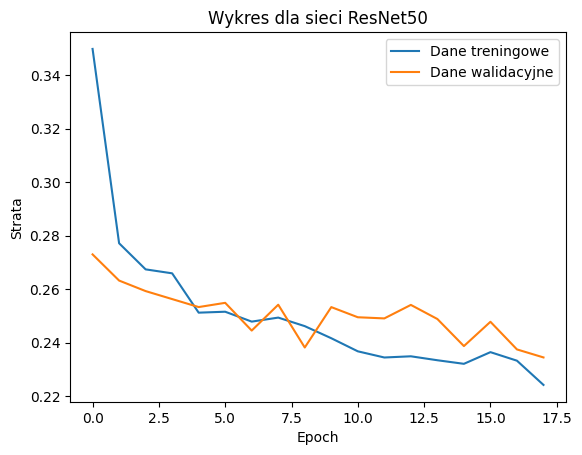

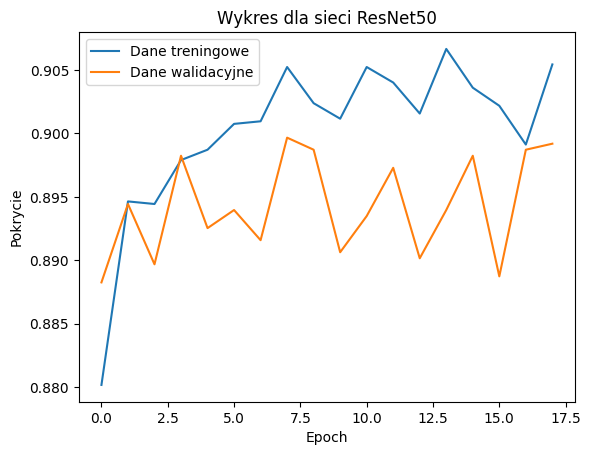

In [62]:
metrics = ['loss', 'accuracy']
metryki = ['Strata', 'Pokrycie']
i = 0
for metric in metrics:
    plt.plot(history.history[metric], label='Dane treningowe')
    plt.plot(history.history[f'val_{metric}'], label='Dane walidacyjne')
    plt.xlabel('Epoch')
    plt.ylabel(metryki[i])
    plt.legend(loc='best')
    plt.title("Wykres dla sieci ResNet50")
    plt.show()
    i += 1

In [63]:
test_data

,lesion_id,image_id,dx,dx_type,age,sex,localization,binary_disease
1617,HAM_0007180,ISIC_0033272,mel,histo,65.0,male,face,mel
8128,HAM_0007195,ISIC_0031923,nv,histo,40.0,female,lower extremity,non-mel
2168,HAM_0001835,ISIC_0026652,mel,histo,65.0,male,back,mel
1090,HAM_0000465,ISIC_0030583,bkl,consensus,35.0,female,trunk,non-mel
7754,HAM_0001720,ISIC_0034010,nv,histo,45.0,male,abdomen,non-mel
...,...,...,...,...,...,...,...,...
4635,HAM_0006000,ISIC_0032121,nv,follow_up,45.0,male,trunk,non-mel
8386,HAM_0002986,ISIC_0028706,nv,histo,70.0,female,foot,non-mel
3707,HAM_0004793,ISIC_0028102,nv,follow_up,60.0,male,lower extremity,non-mel
1839,HAM_0001344,ISIC_0033055,mel,histo,45.0,male,back,mel


In [64]:
test_data['image_id'] = test_data['image_id'].apply(lambda x: x + '.jpg')

In [67]:
test_data["binary_disease"].value_counts()

binary_disease
non-mel    2658
mel         347
Name: count, dtype: int64

In [65]:
test_generator = datagen.flow_from_dataframe(
    dataframe=test_data,
    directory='./dataset/data_with_mask_otsu',
    x_col='image_id',
    y_col='binary_disease',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  
)
y_pred_probs = model.predict(test_generator) 
y_pred = np.argmax(y_pred_probs, axis=1)    
y_true = test_generator.classes  

Found 3005 validated image filenames belonging to 2 classes.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 190ms/step


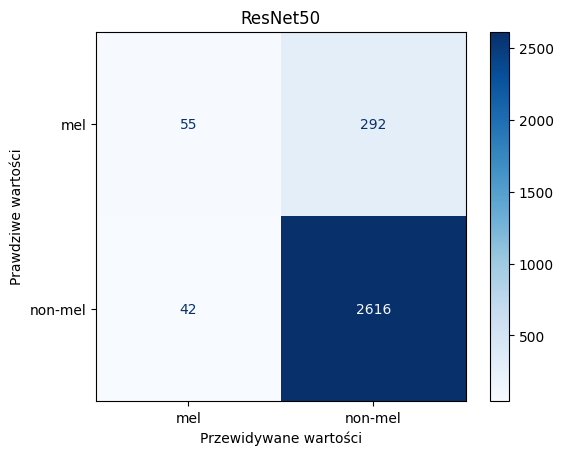

In [68]:
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)

plt.xlabel("Przewidywane wartości")
plt.ylabel("Prawdziwe wartości")
plt.title("ResNet50")
plt.show()

In [69]:
report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
print(report)

              precision    recall  f1-score   support

         mel       0.57      0.16      0.25       347
     non-mel       0.90      0.98      0.94      2658

    accuracy                           0.89      3005
   macro avg       0.73      0.57      0.59      3005
weighted avg       0.86      0.89      0.86      3005



Balanced

In [70]:
df = pd.read_csv("dataset/HAM10000_metadata.csv")
df_binary = df.copy()
df_binary['binary_disease'] = df_binary['dx'].apply(lambda x: 'mel' if x == 'mel' else 'non-mel')
target_size = 1000
balanced_data = df_binary.groupby('binary_disease', group_keys=False).apply(
    lambda x: x.sample(n=target_size, replace=True, random_state=42)
).reset_index(drop=True)

/var/folders/yz/bms59l5j5cl16ztb19ty54s40000gn/T/ipykernel_96038/1451520059.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_data = df_binary.groupby('binary_disease', group_keys=False).apply(


In [71]:
balanced_data, test_data = train_test_split(balanced_data, test_size=0.3, random_state=42)

In [72]:
balanced_data['image_id'] = balanced_data['image_id'].apply(lambda x: x + '.jpg')

In [73]:
datagen = ImageDataGenerator(
    validation_split=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    zoom_range=0.3,
    shear_range=0.2,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_dataframe(
    dataframe=balanced_data,
    directory='/Users/htlusty/Documents/DYPLOMA/dataset/data_with_mask_otsu',
    x_col='image_id',
    y_col='binary_disease',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=balanced_data,
    directory='/Users/htlusty/Documents/DYPLOMA/dataset/data_with_mask_otsu',
    x_col='image_id',
    y_col='binary_disease',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

def create_model(base_model_fn, input_shape, num_classes):
    base_model = base_model_fn(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

input_shape = (128, 128, 3)
num_classes = len(train_generator.class_indices)
epochs = 30


models = {
    #"DenseNet121": DenseNet121,
    "ResNet50": ResNet50,
    #"EfficientNetB0": EfficientNetB0
}

for model_name, base_model_fn in models.items():
    print(f"Training {model_name}...")
    model = create_model(base_model_fn, input_shape, num_classes)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        callbacks=[early_stopping]
    )

    model.save(f'{model_name}_model_binary_balanced.h5', save_format='h5')
    print(f"{model_name} training completed and model saved!")


Found 980 validated image filenames belonging to 2 classes.
Found 420 validated image filenames belonging to 2 classes.
Training ResNet50...
Epoch 1/30


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 294ms/step - accuracy: 0.6326 - loss: 0.8556 - val_accuracy: 0.7333 - val_loss: 0.5272
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 283ms/step - accuracy: 0.7360 - loss: 0.5270 - val_accuracy: 0.7452 - val_loss: 0.4965
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 276ms/step - accuracy: 0.7111 - loss: 0.5317 - val_accuracy: 0.7571 - val_loss: 0.4681
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 298ms/step - accuracy: 0.7642 - loss: 0.4658 - val_accuracy: 0.7524 - val_loss: 0.5016
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 284ms/step - accuracy: 0.7671 - loss: 0.4805 - val_accuracy: 0.7429 - val_loss: 0.5079
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 272ms/step - accuracy: 0.7866 - loss: 0.4665 - val_accuracy: 0.7500 - val_loss: 0.5027
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 269ms/step - accuracy: 0.7750 - loss: 0.4599 - val_accuracy: 0.7619 - val_loss: 0.5015
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 275ms/step - accuracy: 0.7692 - loss: 0.4667 - val_accuracy: 0.7762 - val

ResNet50 training completed and model saved!


In [74]:
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")

Training samples: 980
Validation samples: 420


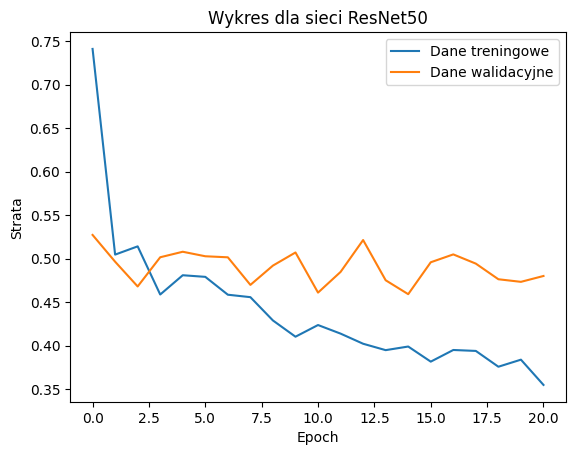

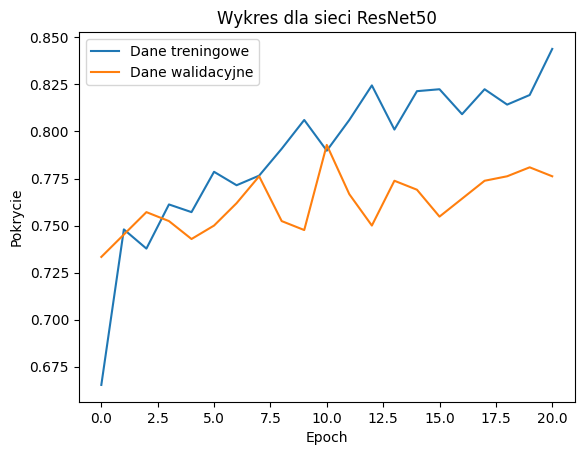

In [75]:
metrics = ['loss', 'accuracy']
metryki = ['Strata', 'Pokrycie']
i = 0
for metric in metrics:
    plt.plot(history.history[metric], label='Dane treningowe')
    plt.plot(history.history[f'val_{metric}'], label='Dane walidacyjne')
    plt.xlabel('Epoch')
    plt.ylabel(metryki[i])
    plt.legend(loc='best')
    plt.title("Wykres dla sieci ResNet50")
    plt.show()
    i += 1

In [77]:
test_data['image_id'] = test_data['image_id'].apply(lambda x: x + '.jpg')

In [78]:
test_generator = datagen.flow_from_dataframe(
    dataframe=test_data,
    directory='/Users/htlusty/Documents/DYPLOMA/dataset/data_with_mask_otsu',
    x_col='image_id',
    y_col='binary_disease',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  
)

Found 600 validated image filenames belonging to 2 classes.


In [79]:
y_pred_probs = model.predict(test_generator) 
y_pred = np.argmax(y_pred_probs, axis=1)  
y_true = test_generator.classes   

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step


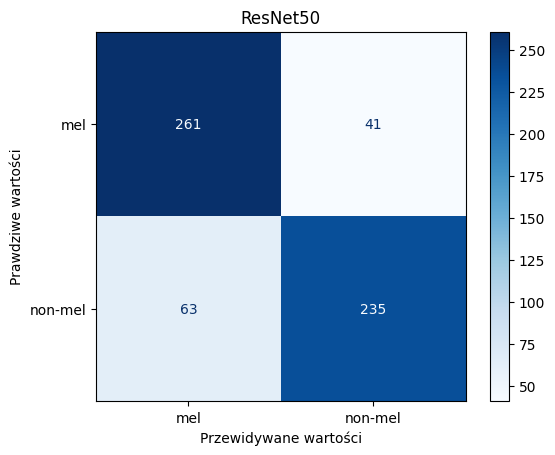

In [80]:
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)

plt.xlabel("Przewidywane wartości")
plt.ylabel("Prawdziwe wartości")
plt.title("ResNet50")
plt.show()

In [81]:
report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
print(report)

              precision    recall  f1-score   support

         mel       0.81      0.86      0.83       302
     non-mel       0.85      0.79      0.82       298

    accuracy                           0.83       600
   macro avg       0.83      0.83      0.83       600
weighted avg       0.83      0.83      0.83       600



# Augmentation

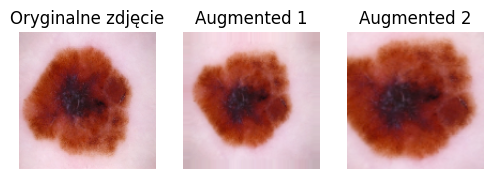

In [219]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

original_image = image.load_img('/Users/htlusty/Documents/DYPLOMA/dataset/data_with_mask_otsu/{}'.format(balanced_data['image_id'].iloc[500]), target_size=(128, 128))
original_image = image.img_to_array(original_image) / 255.0  

aug_datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    #rotation_range=20,
    zoom_range=0.3,
    #shear_range=0.2,
    fill_mode='nearest',
    #brightness_range=[0.8, 1.2]
)

augmented_images = aug_datagen.flow(np.expand_dims(original_image, axis=0), batch_size=1)

fig, axes = plt.subplots(1, 3, figsize=(6, 3))

axes[0].imshow(original_image)
axes[0].set_title("Oryginalne zdjęcie")
axes[0].axis('off')

for i in range(1, 3):
    aug_img = next(augmented_images)[0]  
    axes[i].imshow(aug_img)
    axes[i].set_title(f"Augmented {i}")
    axes[i].axis('off')

plt.show()
